# compute spatiotemporal autocovariances

Run `geohash.ipynb` first to add geohash parquet file

**To do:**

- build example and post stackoverflow question about groupby to array
- update code (follow **to do): 
    - do not drop duplicate, include single velocities in order to better handle normalizationa and deal with mean issue
    - improve performance
- update analysis: think about how to deal with gaps (interpolation? see `interpolate_na`, parametric fit?)
- describe method here


**Useful links:**

- https://www.reddit.com/r/learnpython/comments/4rj7ie/how_to_find_the_difference_between_all_pairs_of/
- https://towardsdatascience.com/finding-distant-pairs-in-python-with-pandas-fa02df50d14b
- http://kuanbutts.com/2017/06/18/dask-geoprocessing/
- https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8
- https://geoffboeing.com/2016/10/r-tree-spatial-index-python/
- https://blog.mapbox.com/a-dive-into-spatial-search-algorithms-ebd0c5e39d2a
- https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html
- https://github.com/uber/h3-py-notebooks/blob/master/notebooks/urban_analytics.ipynb


In [1]:
import os
from glob import glob
import warnings
from tqdm import tqdm

# not working on datarmor
#import datashader as dsh, bokeh, holoviews as hv  # noqa
#hv.extension('bokeh')

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
import pyproj
crs_wgs84 = pyproj.CRS("EPSG:4326")

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4785759.datarmor0/parcels-55081/libparcels_random_b3deb2ed-eac9-4f43-aff4-bdf578092555.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    import logging
    cluster = PBSCluster(walltime="06:00:00")
    #w = cluster.scale(jobs=5) # ibox data collection (part 1)
    w = cluster.scale(jobs=10)
    #w = cluster.scale(jobs=20)
    #
    client = Client(cluster)
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.39:59792 Dashboard: http://10.148.0.39:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


10 jobs = 70 workers = 1.1TB (15GB/worker)

--- 

# parameters

In [3]:
dl = 10 # target tile size
geohash_resolution = 2 # for geohash indexing

d2h=24 # days to hours

# directory where files will be processed
process_dir = os.path.join(ut.scratch, "parcels")

---
# load parcels simulation

In [44]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

pname = 'geohash_p{}'.format(geohash_resolution)
p = pa.parcels_output(root_dir+run_name, 
                      parquets=[pname],
                     )
df = p[pname]

# should persist df here
#df = df.persist()

df.head()

,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,SSU_interp,SSV_interp,Eta_interp,SSS_interp,SST_interp
geohash,,,,,,,,,,,,,,,
04,2011-11-15,31000046,-78.004211,-173.134735,0.0,0.0,0.0,0.0,0.0,0.0,-0.143270,0.093503,-1.148969,33.813637,-1.756193
04,2011-11-15,31000047,-77.646156,-173.440277,0.0,0.0,0.0,0.0,0.0,0.0,-0.057369,0.022395,-1.412224,34.042252,-1.802643
04,2011-11-15,31000048,-77.283386,-173.719879,0.0,0.0,0.0,0.0,0.0,0.0,-0.036992,0.020697,-1.558161,34.113178,-1.810539
04,2011-11-15,31000062,-78.312302,-171.702026,0.0,0.0,0.0,0.0,0.0,0.0,-0.000007,0.000196,-0.140526,31.060963,-1.695898
04,2011-11-15,31000063,-77.961166,-172.041321,0.0,0.0,0.0,0.0,0.0,0.0,-0.131680,0.027052,-1.267136,33.837460,-1.778787


#### tmp do some renaming:

In [45]:
df = df.rename(columns=dict(SSU_interp="mean_zonal_velocity",
                            SSV_interp="mean_meridional_velocity",
                            Eta_interp="mean_sea_level",
                            SSS_interp="mean_salinity",
                            SST_interp="mean_temperature",
                           ),
              )
df.head()

,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,mean_zonal_velocity,mean_meridional_velocity,mean_sea_level,mean_salinity,mean_temperature
geohash,,,,,,,,,,,,,,,
04,2011-11-15,31000046,-78.004211,-173.134735,0.0,0.0,0.0,0.0,0.0,0.0,-0.143270,0.093503,-1.148969,33.813637,-1.756193
04,2011-11-15,31000047,-77.646156,-173.440277,0.0,0.0,0.0,0.0,0.0,0.0,-0.057369,0.022395,-1.412224,34.042252,-1.802643
04,2011-11-15,31000048,-77.283386,-173.719879,0.0,0.0,0.0,0.0,0.0,0.0,-0.036992,0.020697,-1.558161,34.113178,-1.810539
04,2011-11-15,31000062,-78.312302,-171.702026,0.0,0.0,0.0,0.0,0.0,0.0,-0.000007,0.000196,-0.140526,31.060963,-1.695898
04,2011-11-15,31000063,-77.961166,-172.041321,0.0,0.0,0.0,0.0,0.0,0.0,-0.131680,0.027052,-1.267136,33.837460,-1.778787


---

# generate spatial tiles

/home1/datahome/aponte/mit_equinox/mitequinox/drifters.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buff['geometry'] = gdf_buff.buffer(dl)


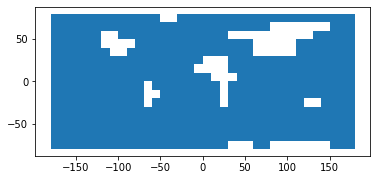

In [46]:
df_boxes, df_buff_boxes = dr.generate_grid_and_geohashes(dl, 
                                                         geohash=geohash_resolution,
                                                         plot=True,
                                                         buffered=True,
                                                        )
hash_boxes = dr.get_geohashes(geohash_resolution)

In [47]:
# load geohash that are effectively used
#index_unique = df.index.unique().compute()
index_unique = df.index.drop_duplicates().compute()
index_unique

Index(['04', '05', '06', '07', '0d', '0e', '0f', '0g', '0h', '0j',
       ...
       'z8', 'z9', 'zb', 'zc', 'zd', 'ze', 'zf', 'zg', 'zs', 'zu'],
      dtype='object', name='geohash', length=748)

In [64]:
# test with one box

ibox = 398 # North of Hawaii

box = (df_boxes
       .loc[ibox]
       .drop(columns="geohash")
       .drop_duplicates()
      )
box_buff = df_buff_boxes.loc[ibox]

# keep only valid geohashes where points are found
valid_geohash = list(set(index_unique) 
                     & set(box_buff
                           .loc[:,"geohash"]
                           .values
                           .astype(str)
                          )
                    )

# first guess based on geohashes
#df_fguess = df.loc[valid_geohash] # this does not work and resembles a bug
df_fguess = df.loc[df.index.isin(valid_geohash)]

# repartition. critical, partitions are very unbalanced otherwise
df_fguess = df_fguess.repartition(partition_size="100MB")

df_fguess = df_fguess.persist()

print("First guess number of partitions = {}".format(df_fguess.npartitions))

df_fguess

First guess number of partitions = 52


,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,mean_zonal_velocity,mean_meridional_velocity,mean_sea_level,mean_salinity,mean_temperature
npartitions=52,,,,,,,,,,,,,,,
04,datetime64[ns],int32,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
87,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bb,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zu,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### ... should illustrate visually the spatial selection process below

In [65]:
_df = df_fguess.loc[df_fguess["time"]==pd.Timestamp("2011-11-15 00:00:00")].compute()

<AxesSubplot:>

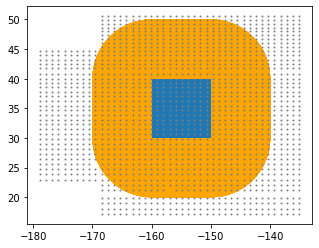

In [66]:
ax=plt.subplot(111)

box_buff.plot(ax=ax, color="orange")
box.geometry.plot(ax=ax)

gdf = gpd.GeoDataFrame(_df, geometry=gpd.points_from_xy(_df.lon, _df.lat))
gdf.plot(ax=ax, color="0.5", markersize=1)

In [67]:
def refine_spatial_selection(df, boxes):
    """ refine with geopandas
    """
    
    box=boxes[0]
    box_buff=boxes[1]
    
    # transform into geopandas dataframe
    gdf = gpd.GeoDataFrame(
        df, 
        geometry=gpd.points_from_xy(df.lon, df.lat),
        crs=crs_wgs84,
    )
    # narrow selection
    _box_buff = box_buff.iloc[[0],:].drop(columns="geohash")
    gdf_refined = gpd.sjoin(gdf, 
                            _box_buff,
                            how='inner',
                            op='intersects',
                           )
    
    # keep geodataframe does not work later on when storing
    
    # flag points within inner domain
    gdf_refined["within_box"] = gdf_refined["geometry"].apply(lambda item: box.contains(item))
    
    # convert back to regular dataframe
    df_refined = pd.DataFrame(gdf_refined.drop(columns='geometry'))
    
    return df_refined

In [68]:
# dev
#_df = df_fguess.get_partition(500).compute()
#out = refine_spatial_selection(_df, [box, box_buff])
#out.plot.scatter(x="lon", y="lat")

In [69]:
meta = dict(**df_fguess.dtypes, index_right=np.int64, within_box=bool)
df_refined = df_fguess.map_partitions(refine_spatial_selection, 
                                      [box, box_buff], 
                                      meta=meta,
                                     )

# should persist here
df_refined = df_refined.persist()

df_refined.head()

,time,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,mean_zonal_velocity,mean_meridional_velocity,mean_sea_level,mean_salinity,mean_temperature,index_right,within_box
geohash,,,,,,,,,,,,,,,,,
87,2011-11-15,37000325,22.072376,-165.322922,0.0,0.0,0.0,0.0,0.0,0.0,-0.114177,0.034200,0.810086,35.169060,24.815969,398,False
87,2011-11-15,37000349,21.182220,-164.281250,0.0,0.0,0.0,0.0,0.0,0.0,-0.069726,0.033210,0.785504,35.126324,24.935398,398,False
87,2011-11-15,37000350,22.072376,-164.281250,0.0,0.0,0.0,0.0,0.0,0.0,-0.143325,0.031412,0.803008,35.177662,24.726086,398,False
87,2011-11-15,37000374,21.182220,-163.239578,0.0,0.0,0.0,0.0,0.0,0.0,-0.051096,0.023006,0.761064,35.131824,24.847448,398,False
87,2011-11-15,37000375,22.072376,-163.239578,0.0,0.0,0.0,0.0,0.0,0.0,-0.199162,0.022785,0.795793,35.180305,24.670881,398,False


In [70]:
# reindex by time, repartition ... kind of heavy computationally

df_refined = (df_refined
              .set_index("time")
              .repartition(partition_size="100MB")
             )

parquet_path = os.path.join(process_dir, 
                            "raw_b{:04d}.parquet".format(ibox),
                           )

df_refined.to_parquet(parquet_path, overwrite=True)

# 400MB archive for ibox = 398

### virtual pair daframe size

In [71]:
ds_size = 400
n_rows = int(ds_size*1e6/4/13) # 13 = number of columns
virtual_product_size = 4*n_rows**2*2*6 # 6 = number of variables
print("original dataset size = {} MB".format(ds_size))
print("original number of rows = {}".format(n_rows))
print("virtual product size = {} TB".format(virtual_product_size/1e12))

original dataset size = 400 MB
original number of rows = 7692307
virtual product size = 2840.236175147952 TB


---
### start pair selection

In [4]:
# build lag grid
ll_scale = 111
dx, x_max = 2, dl*ll_scale # km
dy, y_max = 2, dl*ll_scale # km
tau_max = 30*d2h # hours

x_bins = np.arange(-x_max, x_max, dx) # km
y_bins = x_bins # km
tau_bins = np.arange(0, tau_max, 1)

In [5]:
# select one tile/box
ibox = 398

parquet_path = os.path.join(process_dir,
                            "raw_b{:04d}.parquet".format(ibox),
                           )

df = dd.read_parquet(parquet_path, engine="fastparquet")
df = df[["lat", "lon", 
         "zonal_velocity", "meridional_velocity", 
         "within_box",
        ]]

print("Number of partitions = {}, number of rows = {}"
      .format(df.npartitions, df.index.size.compute()),
     )

df = df.persist()

df.head()

Number of partitions = 17, number of rows = 13545830


,lat,lon,zonal_velocity,meridional_velocity,within_box
time,,,,,
2011-11-15,22.072376,-165.322922,0.0,0.0,False
2011-11-15,33.886242,-141.364578,0.0,0.0,False
2011-11-15,34.679646,-141.364578,0.0,0.0,False
2011-11-15,35.465908,-141.364578,0.0,0.0,False
2011-11-15,36.244972,-141.364578,0.0,0.0,False


<AxesSubplot:xlabel='lon', ylabel='lat'>

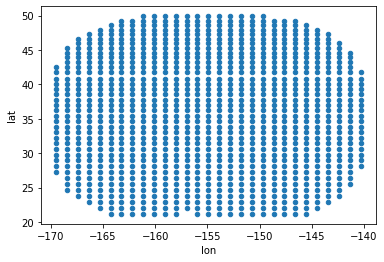

In [6]:
_df = df.loc["2011-11-15 00:00:00"].compute()
_df.plot.scatter(x="lon", y="lat")

In [7]:
# debug: check that we data 1 h after first time stamp
#df["2011-11-15 01:00:00"].compute()
# returns:
# 2011-11-15 01:00:00	34.683760	-163.237952	-1.428824e-08	1.058719e-06	False
# 2011-11-15 01:00:00	33.888304	-163.233156	1.858430e-06	7.684792e-07	False
# so this is a check

In [8]:
worker_RAM = 10 # GB
n_col = len(df.columns)
rows = int(np.sqrt(worker_RAM*1e9/(2*n_col*4)))
p_size_even = rows*n_col*4 /1e6

print("even distribution: {} rows, {:.2f} MB".format(rows, p_size_even))

even distribution: 15811 rows, 0.32 MB


In [9]:
# roll over time
t_min = df.index.min().compute()
t_max = df.index.max().compute()
delta_t = pd.Timedelta(tau_max, unit='h')

In [10]:
def process_time_chunk(df, 
                       t, ibox, it, 
                       partition_size,
                       overwrite=False,
                       **kwargs,
                      ):
    """ Process on time chunk (typically one month, could be decreased to ease load)
    
    Parameters
    ----------
    df: dask.dataframe
        input dataframe
        
    """
    
    zarr_path = os.path.join(process_dir,
                             "C_b{:04d}_t{:02d}.zarr".format(ibox, it),
                            )
    
    # exit if relevant
    if os.path.isdir(zarr_path) and not overwrite:
        return
    
    df_right = df.loc[str(t):str(t+delta_t), :] # will end up being df_small
    df_left = df.loc[str(t):str(t+2*delta_t), :]

    # repartition
    df_left = df_left.repartition(partition_size="{}MB".format(partition_size))
    df_right = df_right.repartition(partition_size="{}MB".format(partition_size))

    # add temp_key
    df_left = df_left.assign(temp_key=1)
    df_right = df_right.assign(temp_key=1)

    df_left = df_left.reset_index().persist() #test
    df_right = df_right.reset_index().persist() #test
        
    # manually loop over partitions and load one:
    #print("Number of partitions: {}".format(df_right.npartitions))

    bins = [x_bins, y_bins, tau_max]

    # first deserialization is expensive, speed up with haversine in notebook?

    # loop around all partitions of the right array
    # this is a slow loop
    #for partition in tqdm(range(3)): # debug
    for partition in tqdm(range(df_right.npartitions)):
        pair_bin_store_partition(partition, 
                      df_left, df_right, 
                      bins, 
                      ibox, it,
                      overwrite=overwrite,
                      **kwargs,
                     )
        # could incrementally update histogram here
    
    # combine partition outputs and convert to xarray
    ds = merge_histograms(ibox, it)
    
    # store
    ds.to_zarr(zarr_path, 
               mode="w",
              )
        
    # clean up partition data? probably a good idea
    # zarrs = glob(os.path.join(ut.scratch, "parcels/paired_b{:04d}_t{:02d}_p*.parquet".format(ibox, it)))
    # for z in zarrs:
    #     shutil.rmtree(z)

def pair_bin_store_partition(partition, 
                      df_left, df_right, 
                      bins,
                      ibox, it, 
                      group=True,
                      overwrite=False,
                      verbose=False, 
                     ):
    """ 
    Forms all pairs from two dataframes
    Compute time and spatial lags
    Bin and store
    """
    
    out_path = os.path.join(process_dir,
                            "paired_b{:04d}_t{:02d}_p{:04d}.parquet"
                            .format(ibox, it, partition)
                           )
    if os.path.isdir(out_path) and not overwrite:
        print(out_path+" exists and will not be overwritten")
        return
                
    df_small = df_right.get_partition(partition).compute()
    #df_small = df_small.iloc[:10] # debug

    merged_ddf = dd.merge(df_left, df_small, on="temp_key", suffixes=("_left", "_right"))
    merged_ddf = merged_ddf[merged_ddf.time_left >= merged_ddf.time_right]

    deltas = merged_ddf.map_partitions(compute_lags_and_products, bins)
    #deltas = deltas.set_index("dt") # done later on at read time

    # could loop over dt here and do the groupby
    if group:
        
        #meta = dict(dx=int, dy=int, 
        #            uu_sum=float, uu_count=int,
        #            vv_sum=float, vv_count=int,
        #           )
        #_index = pd.MultiIndex.from_arrays([[],[]], names=(None, None))
        #meta = pd.DataFrame([], index=_index, columns=meta)
        
        # to do: try dt, dx, dy simultaneous groupby
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            dxdydt = deltas.groupby(["dt"]).apply(_spatial_binning)
            
        dxdydt = dxdydt.reset_index().drop(columns="level_1")
        dxdydt = dxdydt.repartition(partition_size="100MB")
        # can't use meta here for non trivial reasons
        
        # storing to parquet may not be necessary if we transform to xarray dataset
        # ** to do: try skipping file storage below and directly convert to xarray dataset
        #           leverage merge_histogram / to_array_and_store
        #           return ds
        dxdydt.to_parquet(out_path, overwrite=True)

    else:
        try:
            deltas.to_parquet(out_path, overwrite=True)
        except:
            print("pair_bin_store_partition crashed for "
                  +"ibox={}, it={}, partition={}".format(ibox, it, partition))
    
    if verbose:
        print(" partition {} done".format(partition))
        
def compute_lags_and_products(df, bins):
    """ 
    From a table with each row containing a pair:
      - computes the time and spatial lags between points and round
      - add variables (e.g. velocity) cross-products to the table
    """
    x_bins = bins[0]
    y_bins = bins[1]
    tau_max = bins[2]
    
    df = df.copy()
    # **to do: drop deleting duplicates (will later provide variance)
    df = df.loc[ ( (df["zonal_velocity_left"]!=df["zonal_velocity_right"]) 
                  |(df["lon_left"]!=df["lon_right"]) 
                  |(df["lat_left"]!=df["lat_right"])
                 )
                & (df["within_box_left"] | df["within_box_right"])
               ]
    #
    # should use cartopy or other?
    dx = dr.haversine(df["lon_right"], df["lat_right"], df["lon_left"], df["lat_right"])
    dx = np.sign(df["lon_right"]-df["lon_left"]) * dx
    df["dx"] = pd.cut(dx, bins=x_bins, labels=False)
    #
    dy = dr.haversine(df["lon_right"], df["lat_right"], df["lon_right"], df["lat_left"])
    dy = np.sign(df["lat_right"]-df["lat_left"]) * dy    
    df["dy"] = pd.cut(dy, bins=y_bins, labels=False)
    #
    df["dt"] = (df["time_left"]-df["time_right"])/pd.Timedelta("1H")
    #
    df = df.loc[df["dt"]<tau_max]
    df = df.dropna(subset=["dx", "dy", "dt"])
    
    # add velocity cross-product
    df["uu"] = df["zonal_velocity_left"] * df["zonal_velocity_right"]
    df["vv"] = df["meridional_velocity_left"] * df["meridional_velocity_right"]
    
    # ** to do: keep single velocity, will provide later the mean
    
    return df[["dx", "dy", "dt", "uu", "vv"]]

def _spatial_binning(df):
    """ Bin as a function of lags, sum&count
    """
    dxdy = (df
            .groupby(["dx", "dy"])[["uu","vv"]]
            .agg(["sum", "count"])
            .reset_index()
           )
    _flatten_column_names(dxdy)
    return dxdy

def _flatten_column_names(df):
    """ From nested columns to regular column names
    """
    new_names = ['_'.join(col).strip() if col[1] else col[0] 
                 for col in df.columns.values
                ]
    df.columns = new_names
    
#def merge_histograms(ibox, it, npartition_max=500):
def merge_histograms(ibox, it, nparquets_max=20):
    """ For one time chunk:
    - combine several histogramms into a single one
    - transform into xarray
    """
    
    # create scratch dir
    tmp_dir = os.path.join(process_dir, "tmp")
    # create tmp_dir if not existing
    if not os.path.isdir(tmp_dir):
        os.mkdir(tmp_dir) 
    # cleanup files in tmp_dir
    for f in glob(tmp_dir+"/*"):
        os.remove(f)
    
    #
    suffix = "b{:04d}_t{:02d}".format(ibox, it)
    parquet_path = os.path.join(process_dir,
                                "paired_"+suffix+"_p????.parquet",
                               )
    parquet_files = sorted(glob(parquet_path))
    
    for p0 in tqdm(list(range(0, len(parquet_files), nparquets_max))):

        df = dd.read_parquet(parquet_files[slice(p0, min(p0+nparquets_max, len(parquet_files)))])
        #print("Number of partitions = {}".format(df.npartitions))

        ## force partitionnnig per dt

        #for p0 in tqdm(range(0, df.npartitions, npartition_max)):
        #_ddf = dd.concat([df.get_partition(p) for p in range(p0, p0+npartition_max)]) # too slow for some reason
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")    
            _df = (df
                   .groupby("dt", group_keys=False)
                   .apply(to_array_and_store, 
                          tmp_dir, 
                          suffix+"_p{:03d}".format(p0), 
                         )
                   .compute()
                  )

    # the compute above is necessary to trigger and complete calculations prior to 
    # combination with 
    
    ds = combine_arrays(os.path.join(tmp_dir, suffix),
                        x_bins, y_bins, tau_bins,
                       )
    
    return ds

def to_array_and_store(df, output_dir, prefix):
    """ group on dx, dy and store as netcdf
    """
    
    dt = df.name # extract group key (dt)
    _df = df.drop(columns=["dt"]).groupby(["dx", "dy"]).sum()

    ds = xr.Dataset.from_dataframe(_df) # setting sparse arg could be useful?
    ds = ds.expand_dims({"dt": [dt]})

    out_path = os.path.join(output_dir, 
                            prefix+"_{:04d}.nc".format(int(dt)),
                           )
        
    ds.to_netcdf(out_path, mode='w')
    return _df.mean()

def combine_arrays(path, x_bins, y_bins, tau_bins):
    """ Combine several sub histogramms into a single one
    """
    
    files = sorted(glob(path+ "*.nc"))
    
    ds = xr.open_mfdataset(files,
                           concat_dim="dt",
                           combine="nested",
                           join="outer",
                           parallel=True,
                           #auto_close=, # should be True now, which is probably a good thing
                           #lock=,
                          )

    ds = ds.groupby("dt").sum() #.persist()
    
    # create dummy dataset to fill empty lags
    dummy = xr.Dataset(coords=dict(dx=(["dx"], np.arange(x_bins.size-1)),
                                   dy=(["dy"], np.arange(y_bins.size-1)),
                                   dt=(["dt"], np.arange(tau_bins.size)),
                                  ),
                      )
    ds = xr.merge([ds, dummy])

    # fix coords
    ds = ds.assign_coords(
                  dx=("dx", (x_bins[:-1]+x_bins[1:])*.5),
                  dy=("dy", (y_bins[:-1]+y_bins[1:])*.5),
                  dt=("dt", tau_bins/24), # convert lags to days
    )

    return ds

In [13]:
# dev

_path = "/home1/scratch/aponte/parcels/tmp/b0398_t00_"

ds = (combine_arrays(_path,
                    x_bins, y_bins, tau_bins,
                   )
      .persist()
     )


# store
ds.to_zarr(zarr_path, 
           mode="w",
          )


### big processing 

For some reason the computation below needs to be started once, interrupted and relaunched

In [ ]:
t=t_min
it = 0
overwrite = False
partition_factor = 3

def is_zarr(ibox, it):
    z = os.path.join(process_dir, 
                     "C_b{:04d}_t{:02d}.zarr".format(ibox, it),
                    )
    return os.path.isdir(z)

while t < t_max:
    
    print("--- Processing {} to {}".format(t.strftime("%x"), (t+delta_t).strftime("%x")))
    
    if overwrite or not is_zarr(ibox, it):
        # partition_factor helps with memory overload
        process_time_chunk(df, 
                           t, ibox, it, 
                           p_size_even/partition_factor,
                           group=True,
                           overwrite=overwrite,
                          )
        # may add conversion to xarray in process_time_chunk
        print(' time chunk {} done ---'.format(it))
    else:
        print(' time chunk {} skipped ---'.format(it))
    
    t=t+delta_t
    it+=1

In [ ]:
# stopped after 49 iterations (/250, 20%)
# 1h35 our of 6h43
# should try with 20 workers to see if there is speed up
# 1 iteration = 2 min

# 20%|█▉        | 49/250 [1:38:17<6:43:12, 120.36s/it]
# 64%|██████▍   | 160/250 [5:58:15<3:21:31, 134.35s/it]
# 74%|███████▎  | 184/250 [1:13:40<26:25, 24.02s/it]   



---
## inspect output

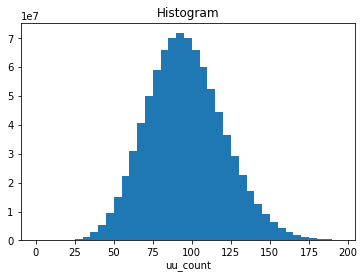

In [41]:
zarr_path = os.path.join("/home1/scratch/aponte/parcels",
                         "C_b{:04d}_t{:02d}.zarr".format(ibox, 0),
                        )
ds = xr.open_zarr(zarr_path).persist()

_ = ds["uu_count"].plot(bins=np.arange(0,200,5))

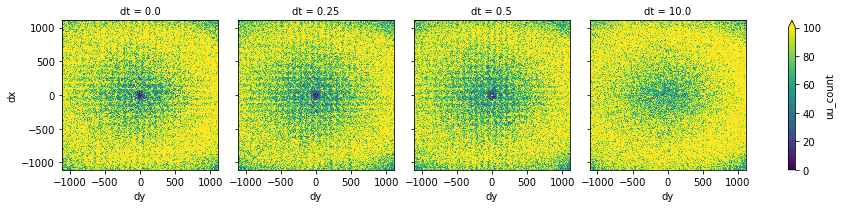

In [42]:
ds["uu_count"].sel(dt=[0., .25, .5, 10.], method='nearest').plot(col="dt", vmax=100)

In [43]:
#count = ds["uu_count"]
count = ds["uu_count"].where(ds["uu_count"]>10)
#count = ds["uu_count"].where(ds["uu_count"]>10, other=10)
C = ds["uu_sum"]/count
C_norm = C.sel(dt=0., dx=0., dy=0., method="nearest").compute()
C = C/C_norm

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


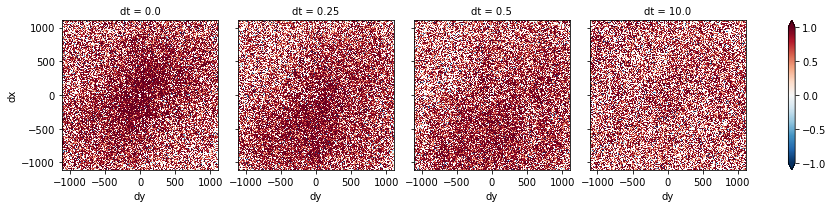

In [44]:
np.log10(C).sel(dt=[0., .25, .5, 10.], method='nearest').plot(col="dt", vmax=1.)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


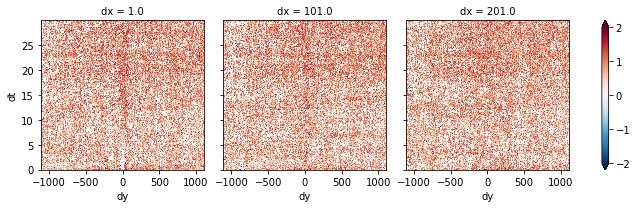

In [45]:
np.log10(C).sel(dx=[0., 100, 200], method='nearest').plot(col="dx", vmax=2)

In [46]:
C_dt = C.sel(dx=slice(-20, 20), dy=slice(-20, 20)).mean(["dx", "dy"]).compute()

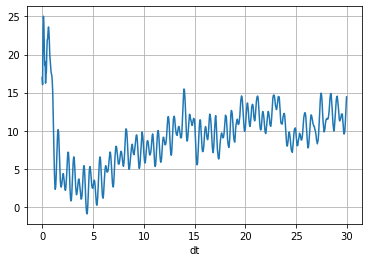

In [47]:
ax = plt.subplot(111)
C_dt.plot(ax=ax)
ax.grid()

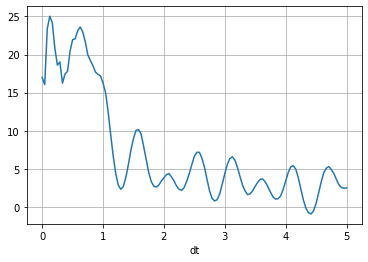

In [48]:
ax = plt.subplot(111)
C_dt.sel(dt=slice(0,5)).plot(ax=ax)
ax.grid()

In [26]:
# 
suffix = "b{:04d}_t{:02d}".format(ibox, it)
base_name = "parcels/paired_b{:04d}_t{:02d}_p????.parquet".format(ibox, it)
parquet_path = os.path.join(ut.scratch,
                            base_name
                           )

_df0 = dd.read_parquet(glob(parquet_path))
print("Number of partitions = {}".format(df.npartitions))

# force partitionnnig per dt
tmp_dir = "/home1/scratch/aponte/parcels/tmp/"
# cleanup files 
for f in glob(tmp_dir+"*"):
    os.remove(f) 

with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    _df1 = (_df0
           .groupby("dt", group_keys=False)
           .apply(to_array_and_store, tmp_dir, suffix)
           .compute()
          )

Number of partitions = 5


In [35]:
files = sorted(glob(os.path.join(tmp_dir, "*.nc")))

ds = xr.open_mfdataset(files,
                       concat_dim="dt",
                       combine="nested",
                       join="outer", 
                       parallel=True,
                      )

In [36]:
ds

<xarray.Dataset>
Dimensions:   (dt: 720, dx: 1109, dy: 1109)
Coordinates:
  * dy        (dy) int64 0 1 2 3 4 5 6 7 ... 1102 1103 1104 1105 1106 1107 1108
  * dt        (dt) float64 0.0 1.0 2.0 3.0 4.0 ... 715.0 716.0 717.0 718.0 719.0
  * dx        (dx) int64 0 1 2 3 4 5 6 7 ... 1102 1103 1104 1105 1106 1107 1108
Data variables:
    uu_sum    (dt, dx, dy) float32 dask.array<chunksize=(1, 1109, 1109), meta=np.ndarray>
    uu_count  (dt, dx, dy) float64 dask.array<chunksize=(1, 1109, 1109), meta=np.ndarray>
    vv_sum    (dt, dx, dy) float32 dask.array<chunksize=(1, 1109, 1109), meta=np.ndarray>
    vv_count  (dt, dx, dy) float64 dask.array<chunksize=(1, 1109, 1109), meta=np.ndarray>

In [32]:
_dt = np.array([int(xr.open_dataset(f)["dt"].values) for f in files])
np.diff(_dt)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [34]:
for f in files:
    #print(xr.open_dataset(f).dims)
    print(xr.open_dataset(f)["dy"].values)

[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 1107 1108]
[   0    1    2 ... 1106 110

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

ValueError: Resulting object does not have monotonic global indexes along dimension dy

In [ ]:
ds

In [17]:
files = sorted(glob(os.path.join(tmp_dir, "*.nc")))

ds = xr.open_mfdataset(files,
                       concat_dim="dt",
                       #combine="by_coords",
                       join="outer", 
                       parallel=True,
                      )

# create dummy dataset to fill empty lags
dummy = xr.Dataset(coords=dict(dx=(["dx"], np.arange(x_bins.size-1)),
                               dy=(["dy"], np.arange(y_bins.size-1)),
                               dt=(["dt"], np.arange(tau_bins.size)),
                              ),
                  )
ds = xr.merge([ds, dummy])

# fix coords
ds = ds.assign_coords(
              dx=("dx", (x_bins[:-1]+x_bins[1:])*.5),
              dy=("dy", (y_bins[:-1]+y_bins[1:])*.5),
              dt=("dt", tau_bins/24), # convert lags to days
)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

ValueError: Resulting object does not have monotonic global indexes along dimension dy

### Need to merge one last time over chunks of time

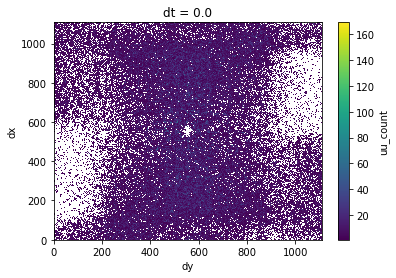

In [48]:
ds["uu_count"].isel(dt=0).plot()

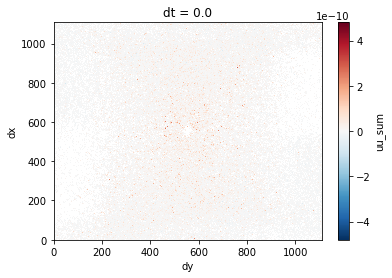

In [47]:
ds["uu_sum"].isel(dt=0).plot()


## illustration:

- plot all points in geographical space (with counts of points)

- plot all pairs in geographical space, lag space (with count of pairs)


---

In [19]:
cluster.close()